# SETUP AND LIBRARY IMPORTS

In [1]:
!pip install -q torchxrayvision
!pip install -q grad-cam

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
import torchxrayvision as xrv
from torchxrayvision.datasets import imread, apply_transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
from tqdm.notebook import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  G

# EXPERIMENT CONFIGURATION

In [2]:
class CFG:
    DATA_DIR = "/kaggle/input/padchest-buat-ta/"
    SUBFOLDERS = ["folder_1", "folder_2", "folder_3"]
    CSV_PATH = "/kaggle/input/padchest-buat-ta/PADCHEST.csv"
    
    # Model Parameters
    MODEL_NAME = "vit_b_16"
    IMG_SIZE = 224
    
    # Training Parameters
    BATCH_SIZE = 32
    SEED = 2025
    
    # Phase 1: Warm-up
    WARMUP_EPOCHS = 2
    WARMUP_LR = 1e-3
    
    # Phase 2: Fine-tuning
    FINETUNE_EPOCHS = 10
    FINETUNE_LR = 5e-6
    
    # Target Labels
    TARGET_LABELS = ["Infiltration", "Effusion"]

    # Focal Loss Parameters
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0

    # Early Stopping
    PATIENCE = 3

# HELPER CLASSES

In [3]:
# Loss Function Class
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        valid_mask = ~torch.isnan(targets)
        if self.reduction == 'mean': return torch.mean(focal_loss[valid_mask])
        elif self.reduction == 'sum': return torch.sum(focal_loss[valid_mask])
        else: return focal_loss

In [4]:
# Custom Dataset Class
class PadChestMultiFolderDataset(xrv.datasets.PC_Dataset):
    def __init__(self, imgpath, subfolders, **kwargs):
        self.subfolders = subfolders
        super().__init__(imgpath=imgpath, **kwargs)
    def __getitem__(self, idx):
        sample = {"idx": idx, "lab": self.labels[idx]}
        imgid = self.csv['ImageID'].iloc[idx]
        found_path = None
        for folder in self.subfolders:
            potential_path = os.path.join(self.imgpath, folder, folder, imgid)
            if os.path.exists(potential_path):
                found_path = potential_path
                break
        if found_path is None: raise FileNotFoundError(f"{imgid} not found")
        img = imread(found_path)
        img = img.astype(np.float32) / 65535.0
        sample["img"] = img
        sample = apply_transforms(sample, self.transform)
        sample = apply_transforms(sample, self.data_aug)
        return sample["img"], sample["lab"]

# FUNCTIONS DEFINITION

In [5]:
# Training & Evaluation Functions
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device, desc="Evaluating"):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    aucs = {}
    for i, label_name in enumerate(CFG.TARGET_LABELS):
        valid_mask = ~np.isnan(all_labels[:, i])
        if np.sum(valid_mask) > 0:
            aucs[label_name] = roc_auc_score(all_labels[valid_mask, i], all_preds[valid_mask, i])
    avg_auc = np.nanmean(list(aucs.values()))
    return running_loss / len(loader.dataset), avg_auc, aucs, all_preds, all_labels

In [6]:
# --- Final Evaluation and Visualization Functions ---
def evaluate_with_optimal_thresholds(y_true, y_preds, labels):
    print("\nFinding Optimal Thresholds (based on F1-Score)")
    optimal_thresholds = {}
    for i, label_name in enumerate(labels):
        mask = ~np.isnan(y_true[:, i])
        true_subset = y_true[mask, i].astype(int)
        preds_subset = y_preds[mask, i]
        threshold_candidates = np.arange(0.05, 0.95, 0.01)
        f1_scores = [f1_score(true_subset, (preds_subset > t).astype(int)) for t in threshold_candidates]
        best_threshold = threshold_candidates[np.argmax(f1_scores)]
        optimal_thresholds[label_name] = best_threshold
        print(f"Optimal threshold for '{label_name}': {best_threshold:.2f} (F1-Score: {np.max(f1_scores):.4f})")
    
    print("\n Classification Report (with Optimal Thresholds)")
    y_pred_optimal = np.zeros_like(y_preds)
    for i, label_name in enumerate(labels):
        y_pred_optimal[:, i] = (y_preds[:, i] > optimal_thresholds[label_name]).astype(int)
    report_data = []
    for i, label_name in enumerate(labels):
        mask = ~np.isnan(y_true[:, i])
        true_subset_int = y_true[mask, i].astype(int)
        report_dict = classification_report(true_subset_int, y_pred_optimal[mask, i], output_dict=True, zero_division=0)
        positive_class_metrics = report_dict.get('1', {})
        report_data.append({'Class': label_name, 'Precision': positive_class_metrics.get('precision', 0), 'Recall': positive_class_metrics.get('recall', 0), 'F1-Score': positive_class_metrics.get('f1-score', 0), 'Support': positive_class_metrics.get('support', 0)})
    report_df = pd.DataFrame(report_data)
    report_df['Precision'] = report_df['Precision'].map('{:,.4f}'.format)
    report_df['Recall'] = report_df['Recall'].map('{:,.4f}'.format)
    report_df['F1-Score'] = report_df['F1-Score'].map('{:,.4f}'.format)
    print(report_df.to_string(index=False))
    print("-------------------------------------------------------")
    print("Support: Number of true positive cases in the dataset.")

    print("\nConfusion Matrices (with Optimal Thresholds)")
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(6 * num_labels, 5))
    if num_labels == 1: axes = [axes]
    for i, label_name in enumerate(labels):
        mask = ~np.isnan(y_true[:, i])
        true_subset_int = y_true[mask, i].astype(int)
        cm = confusion_matrix(true_subset_int, y_pred_optimal[mask, i])
        try: tn, fp, fn, tp = cm.ravel()
        except ValueError: tn, fp, fn, tp = 0, 0, 0, 0
        annot = np.array([[f'True Neg\n{tn}', f'False Pos\n{fp}'], [f'False Neg\n{fn}', f'True Pos\n{tp}']])
        sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'"{label_name}" (Thresh: {optimal_thresholds[label_name]:.2f})', fontsize=14)
        axes[i].set_xlabel('Predicted Label'); axes[i].set_ylabel('True Label')
        axes[i].xaxis.set_ticklabels(['Normal', 'Positive']); axes[i].yaxis.set_ticklabels(['Normal', 'Positive'])
    plt.suptitle("Confusion Matrix per Label on Test Set (Optimal)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

def visualize_cam(model, dataset, device):
    print("\nCreating targeted Grad-CAM visualizations...")
    model.eval()
    target_layers = [model.encoder.layers.encoder_layer_11.ln_1]
    def reshape_transform(tensor):
        result = tensor[:, 1:, :]
        batch_size, num_patches, channels = result.shape
        height = width = int(num_patches ** 0.5)
        result = result.reshape(batch_size, height, width, channels)
        result = result.permute(0, 3, 1, 2)
        return result
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    target_cases = {"Normal": [0, 0], "Infiltration Only": [1, 0], "Effusion Only": [0, 1], "Both": [1, 1]}
    found_samples = {}
    print("Searching for specific samples in the test set...")
    for i in range(min(len(dataset), 5000)):
        image_tensor, label = dataset[i]
        label_tuple = tuple(int(l) for l in label)
        for case_name, case_label in target_cases.items():
            if case_name not in found_samples and list(label_tuple) == case_label:
                found_samples[case_name] = (image_tensor, label)
                print(f"  > Found sample for: {case_name}")
        if len(found_samples) == len(target_cases): break
    if not found_samples:
        print("Could not find all specific samples, visualization may be incomplete."); return
    num_found = len(found_samples)
    fig, axs = plt.subplots(num_found, 3, figsize=(12, 4 * num_found))
    if num_found == 1: axs = np.array([axs])
    fig.suptitle("Grad-CAM Analysis (ViT) on Specific Cases", fontsize=16)
    for i, (case_name, (image_tensor, label)) in enumerate(found_samples.items()):
        input_tensor = image_tensor.unsqueeze(0).to(device)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
        rgb_img = (input_tensor * std + mean).squeeze(0).cpu().permute(1, 2, 0).numpy()
        rgb_img = np.clip(rgb_img, 0, 1)
        targets_infiltration = [ClassifierOutputTarget(0)]; targets_effusion = [ClassifierOutputTarget(1)]
        grayscale_cam_infiltration = cam(input_tensor=input_tensor, targets=targets_infiltration)[0, :]
        grayscale_cam_effusion = cam(input_tensor=input_tensor, targets=targets_effusion)[0, :]
        vis_infiltration = show_cam_on_image(rgb_img, grayscale_cam_infiltration, use_rgb=True)
        vis_effusion = show_cam_on_image(rgb_img, grayscale_cam_effusion, use_rgb=True)
        true_labels = f"Infiltration: {label[0]:.0f}, Effusion: {label[1]:.0f}"
        axs[i, 0].imshow(rgb_img); axs[i, 0].set_title(f"Original ({case_name})\n{true_labels}"); axs[i, 0].axis('off')
        axs[i, 1].imshow(vis_infiltration); axs[i, 1].set_title("'Infiltration' Focus"); axs[i, 1].axis('off')
        axs[i, 2].imshow(vis_effusion); axs[i, 2].set_title("'Effusion' Focus"); axs[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [7]:
# --- Initial Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)

# --- Data Transforms ---
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=45,
        translate=(0.15, 0.15),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cuda


In [8]:
# --- DATA SPLIT (70/10/20) ---
print("Splitting data into Train (70%), Validation (10%), and Test (20%)...")
base_dataset = PadChestMultiFolderDataset(
    imgpath=CFG.DATA_DIR, subfolders=CFG.SUBFOLDERS, csvpath=CFG.CSV_PATH,
    views=["PA", "AP"], transform=None, unique_patients=False
)
xrv.datasets.relabel_dataset(CFG.TARGET_LABELS, base_dataset)
y_stratify = np.array([''.join(str(int(l)) for l in label if not np.isnan(l)) for label in base_dataset.labels])
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=CFG.SEED)
train_val_idx, test_idx = next(sss1.split(np.zeros(len(y_stratify)), y_stratify))
train_val_stratify = y_stratify[train_val_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=CFG.SEED)
train_idx_split, val_idx_split = next(sss2.split(np.zeros(len(train_val_stratify)), train_val_stratify))
final_train_idx, final_val_idx = train_val_idx[train_idx_split], train_val_idx[val_idx_split]

train_dataset = Subset(base_dataset, final_train_idx)
train_dataset.dataset.transform = train_transform
val_dataset = Subset(base_dataset, final_val_idx)
val_dataset.dataset.transform = val_test_transform
test_dataset = Subset(base_dataset, test_idx)
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
print(f"Data ready. Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Splitting data into Train (70%), Validation (10%), and Test (20%)...
{'Tuberculosis', 'Tube', 'Aortic Atheromatosis', 'Mass', 'Nodule', 'Aortic Elongation', 'Pneumothorax', 'Hernia', 'Flattened Diaphragm', 'Hilar Enlargement', 'Scoliosis', 'Support Devices', 'Bronchiectasis', 'Edema', 'Cardiomegaly', 'Atelectasis', 'Costophrenic Angle Blunting', 'Emphysema', 'Air Trapping', 'Fracture', 'Fibrosis', 'Granuloma', 'Pneumonia', 'Pleural_Thickening', 'Consolidation', 'Hemidiaphragm Elevation'} will be dropped
Data ready. Train: 66370, Validation: 9482, Test: 18963


# TRAINING

In [9]:
# --- Model and Loss Setup ---
print(f"\nLoading pretrained model: {CFG.MODEL_NAME}")
model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
model.heads.head = nn.Linear(model.heads.head.in_features, len(CFG.TARGET_LABELS))
model = model.to(DEVICE)
criterion = FocalLoss(alpha=CFG.FOCAL_ALPHA, gamma=CFG.FOCAL_GAMMA)

# --- PHASE 1: WARM-UP ---
print("\n--- PHASE 1: WARM-UP (Training Classifier Head Only) ---")
for param in model.parameters(): param.requires_grad = False
for param in model.heads.parameters(): param.requires_grad = True
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.WARMUP_LR)
for epoch in range(CFG.WARMUP_EPOCHS):
    _ = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)

# --- PHASE 2: FINE-TUNING ---
print("\n--- PHASE 2: FINE-TUNING (Training Full Model) ---")
for param in model.parameters(): param.requires_grad = True
optimizer = optim.AdamW(model.parameters(), lr=CFG.FINETUNE_LR)
scheduler = CosineAnnealingLR(optimizer, T_max=CFG.FINETUNE_EPOCHS, eta_min=1e-7)
best_auc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
patience_counter = 0
for epoch in range(CFG.FINETUNE_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, avg_auc, _, _, _ = evaluate(model, val_loader, criterion, DEVICE, "Validating")
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss); history['val_auc'].append(avg_auc)
    scheduler.step()
    print(f"Epoch {epoch+1}/{CFG.FINETUNE_EPOCHS} - Val Results: Loss={val_loss:.4f}, Avg AUC={avg_auc:.4f}")
    if avg_auc > best_auc:
        print(f"Validation AUC improved from {best_auc:.4f} to {avg_auc:.4f}. Saving model...")
        torch.save(model.state_dict(), f"best_model_{CFG.MODEL_NAME}_focal.pth")
        best_auc = avg_auc
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Validation AUC did not improve. Patience: {patience_counter}/{CFG.PATIENCE}")
    if patience_counter >= CFG.PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1} as performance did not improve for {CFG.PATIENCE} epochs.")
        break


Loading pretrained model: vit_b_16


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 203MB/s]



--- PHASE 1: WARM-UP (Training Classifier Head Only) ---


Training:   0%|          | 0/2075 [00:00<?, ?it/s]

Training:   0%|          | 0/2075 [00:00<?, ?it/s]


--- PHASE 2: FINE-TUNING (Training Full Model) ---


Training:   0%|          | 0/2075 [00:00<?, ?it/s]

Validating:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1/10 - Val Results: Loss=0.0119, Avg AUC=0.9020
Validation AUC improved from 0.0000 to 0.9020. Saving model...


Training:   0%|          | 0/2075 [00:00<?, ?it/s]

Validating:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 2/10 - Val Results: Loss=0.0111, Avg AUC=0.9118
Validation AUC improved from 0.9020 to 0.9118. Saving model...


Training:   0%|          | 0/2075 [00:00<?, ?it/s]

Validating:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 3/10 - Val Results: Loss=0.0109, Avg AUC=0.9016
Validation AUC did not improve. Patience: 1/3


Training:   0%|          | 0/2075 [00:00<?, ?it/s]

Validating:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 4/10 - Val Results: Loss=0.0115, Avg AUC=0.8990
Validation AUC did not improve. Patience: 2/3


Training:   0%|          | 0/2075 [00:00<?, ?it/s]

Validating:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 5/10 - Val Results: Loss=0.0151, Avg AUC=0.8928
Validation AUC did not improve. Patience: 3/3

Early stopping triggered at epoch 5 as performance did not improve for 3 epochs.


# EVALUATION



--- PHASE 3: FINAL EVALUATION ON TEST SET ---


Testing:   0%|          | 0/593 [00:00<?, ?it/s]


======= FINAL RESULTS ON TEST SET (WITH FOCAL LOSS) =======
Average AUC: 0.9065
AUC for Infiltration: 0.8509
AUC for Effusion: 0.9621

Finding Optimal Thresholds (based on F1-Score)
Optimal threshold for 'Infiltration': 0.46 (F1-Score: 0.4648)
Optimal threshold for 'Effusion': 0.43 (F1-Score: 0.6476)

 Classification Report (with Optimal Thresholds)
       Class Precision Recall F1-Score  Support
Infiltration    0.3875 0.5805   0.4648     1745
    Effusion    0.6215 0.6760   0.6476      787
-------------------------------------------------------
Support: Number of true positive cases in the dataset.

Confusion Matrices (with Optimal Thresholds)


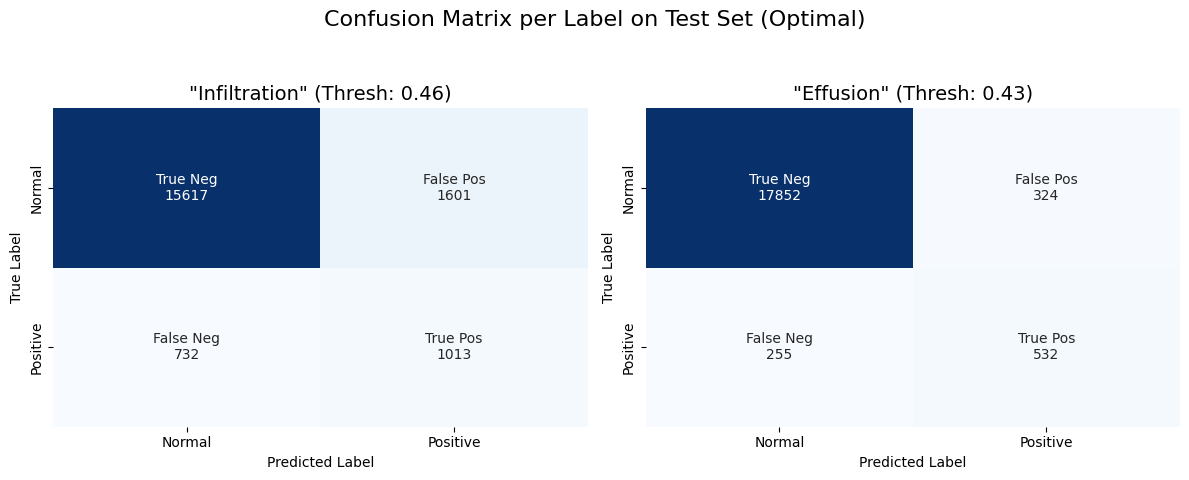


Creating targeted Grad-CAM visualizations...
Searching for specific samples in the test set...
  > Found sample for: Infiltration Only
  > Found sample for: Normal
  > Found sample for: Effusion Only
  > Found sample for: Both


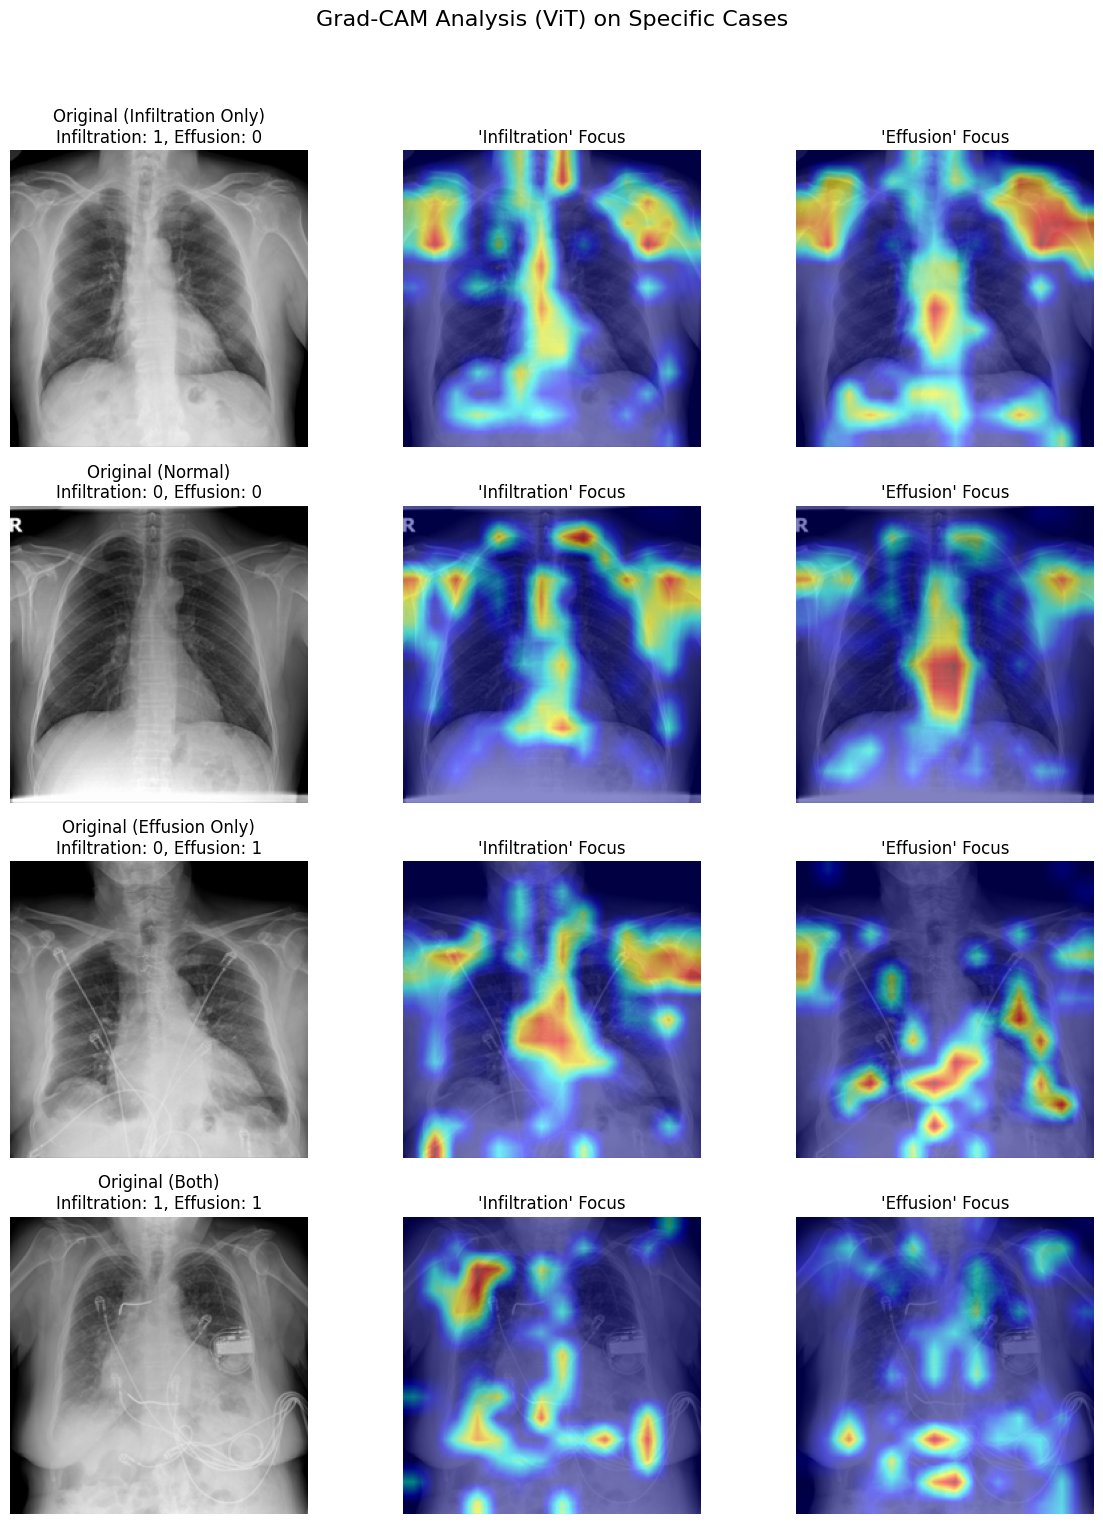

In [ ]:
# --- FINAL EVALUATION ON TEST SET ---
print("\n\n--- PHASE 3: FINAL EVALUATION ON TEST SET ---")
model.load_state_dict(torch.load(f"best_model_{CFG.MODEL_NAME}_focal.pth"))
_, test_avg_auc, test_aucs, test_preds, test_labels = evaluate(model, test_loader, criterion, DEVICE, "Testing")
print(f"\n======= FINAL RESULTS ON TEST SET (WITH FOCAL LOSS) =======")
print(f"Average AUC: {test_avg_auc:.4f}")
for label, auc in test_aucs.items(): print(f"AUC for {label}: {auc:.4f}")
print("==========================================================")

evaluate_with_optimal_thresholds(test_labels, test_preds, CFG.TARGET_LABELS)
visualize_cam(model, test_dataset, DEVICE)

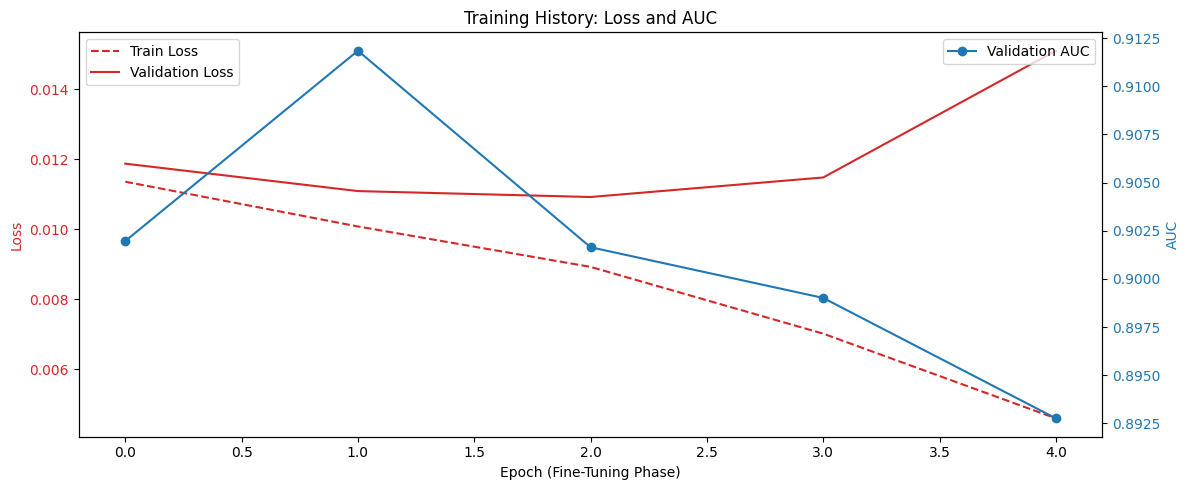

In [11]:
# PLOT TRAINING HISTORY
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_title("Training History: Loss and AUC")
ax1.set_xlabel('Epoch (Fine-Tuning Phase)')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history['train_loss'], color='tab:red', linestyle='--', label='Train Loss')
ax1.plot(history['val_loss'], color='tab:red', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('AUC', color='tab:blue')
ax2.plot(history['val_auc'], color='tab:blue', marker='o', label='Validation AUC')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()